In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading dataset **

In [ ]:
import os

directory_path = '/content/drive/MyDrive/AI stuff/kaggle/'
zip_file_name = 'celebahq-resized-256x256.zip'

# Complete path to storage location of the .zip file of data
zip_path = directory_path + zip_file_name

# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.chdir('/content')
os.getcwd()

# Copy the .zip file into the present directory
!cp '/content/drive/MyDrive/DeepLearning/datasets/celebahq-resized-256x256.zip' .

# Unzip quietly
!unzip -q 'celebahq-resized-256x256.zip'

# View the unzipped contents in the virtual machine
os.listdir()

['.config',
 'celebahq-resized-256x256.zip',
 'celeba_hq_256',
 'drive',
 'sample_data']

In [ ]:
BATCH_SIZES = [64, 64, 32, 16, 8, 4, 4]
#EPOCHS = [1, 1, 1, 1, 1, 1, 1]
EPOCHS = [16, 48, 84, 128, 256, 512, 1024]
Z_DIM = 256
INPUT_SHAPES = [(4, 4), (8, 8), (16, 16), (32, 32), (64, 64), (128, 128), (256, 256)]
LAMBDA = 10 # regularizer weight for gradient penalty
N_CRIT = 1 # number of critic train steps per generator train step

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, LeakyReLU, Reshape, InputLayer, UpSampling2D, AveragePooling2D
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from math import log2

import os
from IPython import display
import time

In [ ]:
def normalize_images(image):
    image = (image - 127.5) / 127.5
    return image

def dataset_loader(image_size, batch_size, data_path = "celeba_hq_256"):
    data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode=None, image_size=image_size, batch_size=batch_size)
    return data

Found 30000 files belonging to 1 classes.
(16, 32, 32, 3)


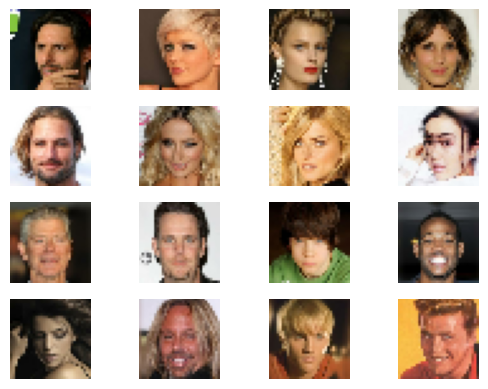

In [ ]:
# Visualising Dataset

x = dataset_loader((32, 32), 16) # image resolution and batch size

for batch in x.take(1):
    print(batch.shape)
    for i in range(16):
        axes = plt.subplot(4, 4, i+1)
        axes.imshow(batch[i].numpy().astype('uint8'))
        axes.axis("off")

In [ ]:
class ELRConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='same', gain=2):
        super(ELRConv2D, self).__init__()
        # we will use conv layer without bias and add bias later
        self._filters = filters
        self.conv_layer = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
        self.scale = tf.sqrt(gain/filters * kernel_size ** 2)
        self.bias = None

    def build(self, input_shape):
        if self.bias is None:
            self.bias = tf.Variable(tf.zeros_initializer()(shape=(self._filters,)), trainable=True)

    def call(self, x):
        return tf.add(self.conv_layer(x * self.scale), self.bias)


In [ ]:
class ELRConv2DTranspose(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='same', gain=2):
        super(ELRConv2DTranspose, self).__init__()
        # we will use conv layer without bias and add bias later
        self.conv_transpose_layer = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
        self.scale = tf.sqrt(gain/filters * kernel_size ** 2)
        self.bias = tf.Variable(tf.zeros_initializer()(shape=(filters,)))

    def call(self, x):
        return tf.add(self.conv_transpose_layer(x * self.scale), self.bias)

In [ ]:
class PixelNorm(tf.keras.layers.Layer):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def call(self, x):
        return tf.divide(x, tf.sqrt(tf.reduce_mean(x**2, axis=3, keepdims=True) + self.epsilon))

In [ ]:
class GenBlock(tf.keras.Model):
    # two conv2d 3x3 layers with conditional pixel norm layer
    def __init__(self, filters):
        super(GenBlock, self).__init__()
        self.upsample = UpSampling2D(size=2, interpolation='nearest')
        self.conv1 = ELRConv2D(filters, kernel_size=3)
        self.conv2 = ELRConv2D(filters, kernel_size=3)
        self.leaky1 = LeakyReLU(0.2)
        self.leaky2 = LeakyReLU(0.2)
        self.pixelnorm = PixelNorm()
        self.upsampled = None

    def call(self, x):
        x = self.upsample(x) # upsampled has 2x channels compared to the final conv output
        self.upsampled = x # this saves the upsampled output
        x = self.leaky1(self.conv1(x))
        x = self.pixelnorm(x)
        x = self.leaky2(self.conv2(x))
        x = self.pixelnorm(x)
        return x

In [ ]:
class DiscBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(DiscBlock, self).__init__()
        self.downsample = AveragePooling2D(strides=2, padding='same')
        self.conv1 = ELRConv2D(int(filters/2), kernel_size=3)
        self.conv2 = ELRConv2D(filters, kernel_size=3)
        self.leaky1 = LeakyReLU(0.2)
        self.leaky2 = LeakyReLU(0.2)
        self.from_rgb = Conv2D(filters, 1, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
        self.downsampled = None

    def call(self, x):
        self.downsampled = self.downsample(x) # filters/2 channels
        self.downsampled = self.from_rgb(self.downsampled) # filters channels

        x = self.leaky1(self.conv1(x)) # filters/2 channels (retains original channel number)
        x = self.leaky2(self.conv2(x)) # filters channels
        x = self.downsample(x) # filters channels

        return x

In [ ]:
class ToRGB(tf.keras.layers.Layer):
    # Layer to get RGB output. For generator
    def __init__(self):
        super(ToRGB, self).__init__()
        self.conv = None

    def build(self, input_shape):
        if self.conv is None:
            self.conv = Conv2D(filters=3, kernel_size=1, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))

    def call(self, x):
        return self.conv(x)

In [ ]:
class FromRGB(tf.keras.layers.Layer):
    # Layer to convert RGB input. For discriminator
    def __init__(self, filters):
        super(FromRGB, self).__init__()
        self._filters = filters
        self.conv = None

    def build(self, input_shape):
        if self.conv is None:
            self.conv = Conv2D(filters=self._filters, kernel_size=1, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))

    def call(self, x):
        return self.conv(x)


In [ ]:
# models list has models starting by generating 4x4 image. it progressively grows to output higher resolution images
# to_rgb layers convert the output of the respective models to rgb image

# check if rgb layers are using correct input channels for their respective model. if the channel size changes, it will re-initialise the layer (I think)
# this causes an issue and throws an error for re initializing the tf variables


class Generator(tf.keras.Model):
    def __init__(self, resolution=1024):
        super(Generator, self).__init__()
        self.models = []
        self.to_rgb_layers = []
        self.filters_limit = int(log2(resolution/4))
        filters_list = [512, 512, 512, 512, 256, 128, 64, 32, 16]

        for i in range(0, self.filters_limit + 1):
            if i == 0:
                model = tf.keras.Sequential([
                    Conv2DTranspose(filters=filters_list[i], kernel_size=4, strides=4, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), input_shape=(1, 1, 256)),
                    LeakyReLU(0.2),
                    ELRConv2D(filters=filters_list[i], kernel_size=3, strides=1),
                    LeakyReLU(0.2),
                    PixelNorm(),
                ])
                #rgb_layer = ToRGB()
                rgb_layer = Conv2D(3, 1, strides=1, padding='same')
                rgb_layer.build((None, (2**i) * 4, (2**i) * 4, filters_list[i])) # build these layers so the variables are initialised. otherwise this will cause error in tf.funtion wrapper
                self.models.append(model)
                self.to_rgb_layers.append(rgb_layer)
                continue

            model = tf.keras.Sequential([
                self.models[i-1],
                GenBlock(filters=filters_list[i]),
            ])
            #rgb_layer = ToRGB()
            rgb_layer = Conv2D(3, 1, strides=1, padding='same')
            rgb_layer.build((None, (2**i) * 4, (2**i) * 4, filters_list[i]))

            self.models.append(model)
            self.to_rgb_layers.append(rgb_layer)


    def build_models(self):
        self.models[self.filters_limit].build()


    def fade_in(self, alpha, upsampled, generated):
        return tf.math.tanh(tf.add(tf.multiply(alpha, generated), tf.multiply(1 - alpha, upsampled)))  # tf.math.tanh(alpha * generated + (1 - alpha) * upsampled)


    def call(self, x, alpha, step):
            if step == 0:
                generated = self.models[step](x)
                rgb = self.to_rgb_layers[step](generated)
                return rgb

            # model[step] gets the right block.
            # the block has previous sequential model at index 0 and GenBlock Model at index 1.
            # GenBlock has upsampled output saved in upsampled variable
            conv_out = self.models[step](x)
            generated = self.to_rgb_layers[step](conv_out)
            upsampled = self.to_rgb_layers[step - 1](self.models[step].layers[1].upsampled) # using previous layers rgb cuz it has 2x channels input which is right for upsampled output
            return self.fade_in(alpha, upsampled, generated)


In [ ]:
# models list contains models. each model has an output block appended at the end. the model is progressively grown from back.
# from_rgb_layers is used to convert rgb layers to have correct number of channels for the models

class Discriminator(tf.keras.Model):
    def __init__(self, resolution=1024):
        super(Discriminator, self).__init__()

        self.models = []
        self.from_rgb_layers = []

        # I have added 16 in the filters list to add filters_list[i+1] channels in the from_rgb layers.
        # this will make rgb layers have correct channel size for respective layers.
        # in disc_block, it internally gets 'filters/2' number of channels for first conv and 'filters' number of channels for second conv layer
        self.filters_limit = int(log2(resolution/4))
        filters_list = [512, 512, 512, 512, 512, 256, 128, 64, 32, 16]

        for i in range(0, self.filters_limit + 1):
            if i == 0:
                model_out = tf.keras.Sequential([
                    InputLayer(input_shape=(4, 4, filters_list[i+1])),
                    ELRConv2D(filters_list[i], kernel_size=3),
                    LeakyReLU(0.2),
                    ELRConv2D(filters_list[i], kernel_size=4),
                    LeakyReLU(0.2),
                    Flatten(),
                    Dense(1)
                ])
                rgb_layer = Conv2D(filters_list[i+1], 1, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
                rgb_layer.build((None, (2 ** i) * 4, (2 ** i) * 4, 3))

                self.models.append(model_out)
                self.from_rgb_layers.append(rgb_layer)

            elif i==1:
                model = tf.keras.Sequential([
                    DiscBlock(filters_list[i])
                ])
                rgb_layer = Conv2D(filters_list[i+1], 1, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
                rgb_layer.build((None, (2 ** i) * 4, (2 ** i) * 4, 3))

                self.models.append(model)
                self.from_rgb_layers.append(rgb_layer)

            elif i==self.filters_limit:
                model = tf.keras.Sequential([
                    Conv2D(filters=int(filters_list[i]/2), kernel_size=1, strides=1, input_shape=(resolution, resolution, filters_list[i+1])),
                    DiscBlock(filters_list[i]),
                    self.models[i - 1],
                ])
                rgb_layer = Conv2D(filters_list[i+1], 1, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
                rgb_layer.build((None, (2 ** i) * 4, (2 ** i) * 4, 3))

                self.models.append(model)
                self.from_rgb_layers.append(rgb_layer)

            else:
                model = tf.keras.Sequential([
                    DiscBlock(filters_list[i]),
                    self.models[i - 1]
                ])
                rgb_layer = Conv2D(filters_list[i+1], 1, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))
                rgb_layer.build((None, (2 ** i) * 4, (2 ** i) * 4, 3))

                self.models.append(model)
                self.from_rgb_layers.append(rgb_layer)

    def build_models(self):
        self.models[self.filters_limit].build()
        self.models[0].build()


    def fade_in(self, alpha, downsampled, conv_out):
        return tf.add(tf.multiply(alpha, conv_out), tf.multiply(1 - alpha, downsampled))  #alpha * conv_out + (1 - alpha) * downsampled

    # minibatch_std is only used by the final block of the discriminator. only thing not working in this model. it doesn't generate gradients
    def minibatch_std(self, x):
        mean_std = tf.math.reduce_mean(tf.math.reduce_std(x, axis=0)) # mean std accross the batch
        #feature_map = tf.constant(mean_std, shape=[batch_shape[0], batch_shape[1], batch_shape[2], 1]) # N x H x W x 1 -> only one channel with mean std
        #temp = tf.constant(1.0, shape=[current_batch_size, 4, 4, 1])
        ones = tf.Variable(tf.ones_like(tf.reduce_mean(x, axis=3, keepdims=True)), trainable=False)
        feature_map = tf.multiply(ones, mean_std)
        return tf.Variable(tf.concat([x, feature_map], axis=3))

    def call(self, x, alpha, step):
        # here step 0 refers to the first model which outputs [1, 1] tensor for 4x4 image.
        # this is to keep things similar when following other model outputs. the model outputs go through self.models[0] to output [1, 1] tensor
        # step 1+ refer models for 8x8 to 1024x1024 input size
        # step = log2(image height or width/4)

        if step == 0:
            x = self.from_rgb_layers[step](x) # convert rgb to have multiple channels (4, 4, 3) -> (4, 4, 512)
            #x = self.minibatch_std(x) # add minimatch_std feature map (4, 4, 512) -> (4, 4, 513)
            conv_out = self.models[0](x) # pass the input with minibatch_std through the model
            return conv_out

        # only reason why step 8 has a separate condition is because it has an extra conv2d layer at index 0.
        elif step==self.filters_limit:
            rgb_out = self.from_rgb_layers[step](x) # convert rgb to have multiple channels (1024, 1024, 3) -> (1024, 1024, 16)
            conv_out = self.models[step].layers[1](rgb_out) # get disc block output of this model (512, 512, 32)
            downsampled = self.models[step].layers[1].downsampled # get downsampled output of this model (512, 512, 32)
            faded = self.fade_in(alpha, downsampled, conv_out) # interpolate these outputs using alpha
            final_out = self.models[step].layers[2](faded) # use the interpolated input for the rest of the progressive blocks (till self.models[1])

        elif step==1:
            rgb_out = self.from_rgb_layers[step](x)
            conv_out = self.models[step].layers[0](rgb_out)
            downsampled = self.models[step].layers[0].downsampled
            faded = self.fade_in(alpha, downsampled, conv_out)
            final_out = faded # because model[1] will directly pass its input to model[0]

        # follows same steps as above, but the layer indices are different
        else:
            rgb_out = self.from_rgb_layers[step](x)
            conv_out = self.models[step].layers[0](rgb_out)
            downsampled = self.models[step].layers[0].downsampled
            faded = self.fade_in(alpha, downsampled, conv_out)
            final_out = self.models[step].layers[1](faded)

        #return self.models[0](self.minibatch_std(final_out))
        return self.models[0](final_out)


In [ ]:
from keras.api._v2.keras import activations
class ProGAN(tf.keras.Model):
    def __init__(self, gen_optimizer, crit_optimizer):
        super(ProGAN, self).__init__()
        self.gen_optimizer = gen_optimizer
        self.crit_optimizer = crit_optimizer
        self.generator = self.create_generator()
        self.critic = self.create_critic()


    def create_generator(self):
        return Generator(resolution=256)


    def create_critic(self):
        return Discriminator(resolution=256)


    def build(self):
        # this is necessary step to initialize the model and hth eoptimizer. not initializing these could cause an error further down the training
        self.generator.build_models()
        self.critic.build_models()

        gen_variables, crit_variables = self.get_model_trainable_variables()
        self.gen_optimizer.build(gen_variables)
        self.crit_optimizer.build(crit_variables)


    def get_model_trainable_variables(self):
        gen_variables = []
        crit_variables = []

        for i in range(self.generator.filters_limit + 1):
            gen_variables.append([*self.generator.models[i].trainable_variables, *self.generator.to_rgb_layers[i].weights])
            crit_variables.append([*self.critic.models[i].trainable_variables, *self.critic.from_rgb_layers[i].weights])

        gen_variables = [variable for variable_list in gen_variables for variable in variable_list]
        crit_variables = [variable for variable_list in crit_variables for variable in variable_list]

        return gen_variables, crit_variables


    @tf.function(reduce_retracing=True)
    def train_step(self, x, alpha, step, current_batch_size):
        # Critic training
        for _ in range(N_CRIT):
            with tf.GradientTape() as tape_c:
                # generate noise with (BATCH_SIZE, 1, 1, Z_DIM) dimensions to generate fake image
                noise = tf.random.normal((current_batch_size, 1, 1, Z_DIM))
                # epsilon for gradient penalty
                epsilon = tf.random.uniform(shape=(current_batch_size, 1, 1, 1), minval=0, maxval=1)

                # Calculate gradient Penalty
                with tf.GradientTape() as gp_t:
                    x_gen = self.generator(noise, alpha, step)
                    interpolated_image = epsilon * x + (1 - epsilon) * x_gen # x_hat
                    gp_t.watch(interpolated_image)
                    c_interpolated = self.critic(interpolated_image, alpha, step) # c_hat
                grads = gp_t.gradient(c_interpolated, interpolated_image)
                l2_norm = tf.sqrt(tf.reduce_sum(grads ** 2, axis=(1, 2, 3)))
                gp = tf.reduce_mean((l2_norm - 1) ** 2)

                # critic output on real and fake images
                critic_real = self.critic(x, alpha, step)
                critic_fake = self.critic(x_gen, alpha, step)

                # critic loss = C(G(z)) - C(x) + lambda*gp
                critic_loss = tf.reduce_mean(critic_fake) - tf.reduce_mean(critic_real) + LAMBDA * gp

            # calculate gradients of critic and apply grads to critic
            grads = tape_c.gradient(critic_loss, self.critic.models[step].trainable_variables)
            self.crit_optimizer.apply_gradients(zip(grads, self.critic.models[step].trainable_variables))
            self.critic_loss = critic_loss

        # Generator training
        noise = tf.random.normal((current_batch_size, 1, 1, Z_DIM))
        with tf.GradientTape() as tape_g:
            x_gen = self.generator(noise, alpha, step)
            critic_fake = self.critic(x_gen, alpha, step)

            # generator loss = -C(G(z))
            gen_loss =  -tf.reduce_mean(critic_fake)

        grads = tape_g.gradient(gen_loss, self.generator.models[step].trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grads, self.generator.models[step].trainable_variables))
        self.gen_loss = gen_loss





In [ ]:
gen_optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0, beta_2=0.99)
crit_optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_1=0, beta_2=0.99)

progan = ProGAN(gen_optimizer, crit_optimizer)

progan.build()

In [ ]:
#noise to visualise the generated images during training
tf.random.set_seed(42)
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 1, 1, Z_DIM], seed=1)

In [ ]:
# reference: https://www.tensorflow.org/tutorials/generative/dcgan
image_dir = '/content/drive/MyDrive/DeepLearning/ProGAN/images'
def generate_and_save_images(model, epoch, step, alpha, test_input, save=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, alpha=alpha, step=step, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.clip(predictions[i] * 0.5 + 0.5, 0, 1))
        plt.axis('off')
    if(save):
        plt.savefig('{}/image_at_step_{}_epoch_{:04d}.png'.format(image_dir,step, epoch))
    plt.show()

# Display a single image using the epoch number
def display_image(step, epoch_no):
    return Image.open('{}/image_at_step_{}_epoch_{:04d}.png'.format(image_dir,step, epoch_no))

In [ ]:
def train_and_checkpoint(train_ds, epochs, step, load_model):
    alpha = tf.Variable(1e-5, trainable=False) # avoids retrace as it uses tf.Variable
    step_ = tf.Variable(step, trainable=False) # used to save in checkpoints
    current_epoch_ = tf.Variable(0, trainable=False)

    # code to save and load model so training can be resumed if its interrupted
    checkpoint_dir = '/content/drive/MyDrive/DeepLearning/ProGAN/weights'
    checkpoint = tf.train.Checkpoint(step_ = step_, current_epoch_ = current_epoch_, alpha=alpha, gen_optimizer=progan.gen_optimizer, crit_optimizer=progan.crit_optimizer, generator=progan.generator, critic=progan.critic)
    checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=2)

    if(load_model):
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
        if checkpoint_manager.latest_checkpoint:
            print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
            step = int(step_)
            epochs = EPOCHS[step]
            train_ds = dataset_loader(INPUT_SHAPES[step], BATCH_SIZES[step])
            train_ds = train_ds.map(normalize_images)
            print("step: {}\ntotal epochs: {}\ncurrent epoch: {}\n".format(step, epochs, int(current_epoch_)))
        else:
            print("Initializing from scratch")

    for epoch in range(int(current_epoch_), epochs + 1):
        start_time = time.time()
        #print("step: ", step)
        print("epoch: ", int(current_epoch_))

        for batch in train_ds:
            alpha.assign_add(1 / (len(train_ds) * epochs * 0.99)) # alpha gradually grows to 1 by the epochs are 99% completed
            progan.train_step(x=batch, alpha=tf.math.minimum(1.0, alpha), step=step, current_batch_size=batch.shape[0])

        # for generating images
        generate_and_save_images(progan.generator, int(current_epoch_), step, alpha, seed, save=False)
        current_epoch_.assign_add(1)

        # save the model every n epochs. n increases with no. of total epochs. I did this so it doesn't save images on each and every epoch during training
        n = 1
        if(epochs == EPOCHS[1]):
            n = 2
        elif(epochs == EPOCHS[2]):
            n = 3
        elif(epochs == EPOCHS[3]):
            n = 4
        elif(epochs == EPOCHS[4]):
            n = 8
        elif(epochs == EPOCHS[5]):
            n = 16
        else:
            n = 32

        if (epoch % n) == 0:
            display.clear_output(wait=True)
            generate_and_save_images(progan.generator, int(current_epoch_), step, alpha, seed, save=True)

        if(epoch % 5) == 0:
            path = checkpoint_manager.save()
            print("checkpoint {}\nsaved at step {} and epoch {}".format(path, step, int(current_epoch_)))

        print ('Time for epoch {} is {} sec'.format(int(current_epoch_), time.time()-start_time))

    display.clear_output(wait=True)
    generate_and_save_images(progan.generator, int(current_epoch_), step, alpha, seed)

    # update variables and save at the end of model iteration
    step += 1
    step_.assign_add(1)
    current_epoch_.assign(0)
    alpha.assign(1e-5)

    path = checkpoint_manager.save()

    # returns incremented step to start the next step for training
    return step



In [ ]:
i=0
load_model=True

while i < len(INPUT_SHAPES):
    image_size = INPUT_SHAPES[i]
    batch_size = BATCH_SIZES[i]
    image_hw = image_size[0]
    epochs = EPOCHS[i]

    data = dataset_loader(image_size, batch_size)
    data = data.map(normalize_images)

    step = int(log2(image_hw/4)) # = i
    print("step: ", step)
    print("image_size: ", image_size)
    print("batch_size: ", batch_size)
    print("no. of epochs: ", epochs)

    i = train_and_checkpoint(data, epochs, step, load_model)
    load_model=False # load the model only the first time after resuming the training







